In [1]:
import networkx as nx
import math

from burn_tree import *

In [43]:
def burn_most_leaves_rooted(tree, verbose=False):
    activators = []
    marked = set()
    bound = math.ceil(math.sqrt(tree.order()))
    
    # First, root at a central vertex (min eccentricity)
    eccens = nx.algorithms.distance_measures.eccentricity(tree)
    root = min(eccens, key=eccens.get)
    
    i = 0
    while tree.order() > 0:
        if verbose:
            print("\nTree size", tree.order())
            print("Nodes:", tree.nodes())
            print("Edges:", tree.edges())
        # Consider all vertices v of height at most i - which N_i[v] covers the most leaves?
        leaves = get_leaves(tree, root=root)
        node_distances = shortest_path_lengths(tree)
        eccens = nx.algorithms.distance_measures.eccentricity(tree)
        
        # Get all vertices within distance i of a leaf
        near_leaves = set()
        for leaf in leaves:
            nhood = get_neighbourhood(tree, source=leaf, radius=i, node_distances=node_distances)
            for node in nhood:
                near_leaves.add(node)
        
        # Remove those that are not >= sqrt(n) dist from the root
        for node in near_leaves:
            if node_distances[root][node] < bound:
                near_leaves.remove(node)
        
        # For all v we just got: take one with max leaves in its neighbourhood
        max_leaves = 0
        max_node = None
        max_nhood = None
        for node in near_leaves:
            nhood = get_neighbourhood(tree, source=node, radius=i, node_distances=node_distances)
            
            num_leaves = 0
            for v in nhood:
                if v in leaves:
                    num_leaves += 1
            
            if num_leaves > max_leaves:
                max_node = node
                max_nhood = nhood
                max_leaves = num_leaves
            elif num_leaves == max_leaves:
                # TODO: tie breaking - max depth OR most nodes that can be removed
            
        # Burn that vertex
        if max_node in activators:
            activators.remove(max_node)
        activators.insert(0, max_node)
        
        # Remove all vertices we can without disconnecting the graph
        
        # TODO: fix this part
            # For each node:
                # Recaluclate eccens
                # Remove a node of max eccen
            # OR: Loop over vertices until there is an iteration where none are removed
        
        sorted_eccens = sorted(eccens.items(), key=lambda kv: kv[1], reverse=True)
        for node, eccen in sorted_eccens:
            # Only remove nodes within the appropriate neighbourhood
            if node in max_nhood:
                temp = tree.copy()
                temp.remove_node(node)
                
                # Only remove if the the tree does not become disconnected
                if temp.order() == 0 or nx.algorithms.components.is_connected(temp):
                    if verbose:
                        print("Removing", node)
                    tree = temp
                elif verbose:
                    print("Not removing", node)
        
        i += 1
    
    return activators

tree = nx.Graph()
for i in range(5):
    tree.add_node(i, key=i)
edges = [(0, 1), (0, 2), (0, 3), (0, 4)]
tree.add_edges_from(edges)
print(list(tree.nodes(data=True)))

bs = burn_most_leaves(tree, verbose=True)
print("\nBurning sequence", bs)

[(0, {'key': 0}), (1, {'key': 1}), (2, {'key': 2}), (3, {'key': 3}), (4, {'key': 4})]

Tree size 5
Nodes: [0, 1, 2, 3, 4]
Edges: [(0, 1), (0, 2), (0, 3), (0, 4)]
Removing 1

Tree size 4
Nodes: [0, 2, 3, 4]
Edges: [(0, 2), (0, 3), (0, 4)]
Removing 2
Removing 3
Removing 4
Removing 0

Burning sequence [0, 1]


In [44]:
import os
import math
from graph_utils import *

# Try burning all the trees in the ./trees directory
DIR_NAME = "./trees"
directory = os.fsencode(DIR_NAME)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        #print(filename)
        filepath = os.path.join(DIR_NAME, filename)
        with open(filepath, 'r') as file:
            adj_mat = create_adj_mat(filepath)
            tree = nx.convert_matrix.from_numpy_matrix(adj_mat)
            #pos = nx.nx_pydot.pydot_layout(tree, prog='dot')
            #nx.draw(tree, pos=pos, with_labels=True)
            
            burning_sequence = burn_most_leaves(tree)
            print('b(G)<={0:2d} | n={1:2d} | ceil(sqrt(n))={2:2d} | {3:15} | {4:20}'.format(len(burning_sequence),
                                                                     tree.order(),
                                                                     math.ceil(math.sqrt(tree.order())),
                                                                     filename,
                                                                     str(burning_sequence)))

b(G)<= 3 | n=12 | ceil(sqrt(n))= 4 | graph_27412.mat | [10, 11, 0]         
b(G)<= 4 | n=20 | ceil(sqrt(n))= 5 | hexane.mat      | [16, 19, 14, 0]     
b(G)<= 3 | n= 8 | ceil(sqrt(n))= 3 | ethane.mat      | [6, 7, 0]           
b(G)<= 4 | n=13 | ceil(sqrt(n))= 4 | graph_60.mat    | [9, 11, 8, 0]       
b(G)<= 2 | n=13 | ceil(sqrt(n))= 4 | graph_88.mat    | [12, 0]             
b(G)<= 4 | n=13 | ceil(sqrt(n))= 4 | graph_156.mat   | [8, 3, 11, 0]       
b(G)<= 4 | n=15 | ceil(sqrt(n))= 4 | graph_626.mat   | [8, 12, 6, 0]       
b(G)<= 3 | n= 6 | ceil(sqrt(n))= 3 | h.mat           | [3, 5, 0]           
b(G)<= 4 | n=14 | ceil(sqrt(n))= 4 | graph_356.mat   | [10, 6, 13, 0]      
b(G)<= 3 | n=12 | ceil(sqrt(n))= 4 | graph_604.mat   | [8, 11, 0]          
b(G)<= 4 | n=12 | ceil(sqrt(n))= 4 | graph_534.mat   | [4, 9, 6, 0]        
b(G)<= 3 | n= 7 | ceil(sqrt(n))= 3 | path.mat        | [6, 3, 0]           
b(G)<= 3 | n=11 | ceil(sqrt(n))= 4 | graph_164.mat   | [5, 8, 0]           
b(G)<= 3 | n

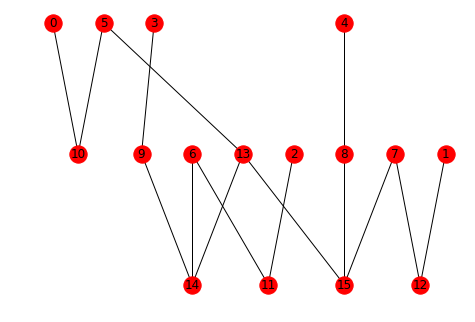

In [45]:
def show_graph(filepath):
    adj_mat = create_adj_mat(filepath)
    tree = nx.convert_matrix.from_numpy_matrix(adj_mat)
    pos = nx.nx_pydot.pydot_layout(tree, prog='dot')
    nx.draw(tree, pos=pos, with_labels=True);

#show_graph('./trees/graph_626.mat')
show_graph('./trees/graph_30698.mat')

In [46]:
#filename = './trees/graph_626.mat'
filename = './trees/graph_30698.mat'
with open(filename, 'r') as file:
    adj_mat = create_adj_mat(filename)
    tree = nx.convert_matrix.from_numpy_matrix(adj_mat)
    #pos = nx.nx_pydot.pydot_layout(tree, prog='dot')
    #nx.draw(tree, pos=pos, with_labels=True)

    burning_sequence = burn_most_leaves(tree, verbose=True)
    print('b(G)<={0:2d} | n={1:2d} | ceil(sqrt(n))={2:2d} | {3:15} | {4:20}'.format(len(burning_sequence),
                                                             tree.order(),
                                                             math.ceil(math.sqrt(tree.order())),
                                                             filename,
                                                             str(burning_sequence)))


Tree size 16
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Edges: [(0, 10), (1, 12), (2, 11), (3, 9), (4, 8), (5, 10), (5, 13), (6, 11), (6, 14), (7, 12), (7, 15), (8, 15), (9, 14), (13, 14), (13, 15)]
Removing 0

Tree size 15
Nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Edges: [(1, 12), (2, 11), (3, 9), (4, 8), (5, 10), (5, 13), (6, 11), (6, 14), (7, 12), (7, 15), (8, 15), (9, 14), (13, 14), (13, 15)]
Removing 10
Removing 5
Not removing 13

Tree size 13
Nodes: [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15]
Edges: [(1, 12), (2, 11), (3, 9), (4, 8), (6, 11), (6, 14), (7, 12), (7, 15), (8, 15), (9, 14), (13, 14), (13, 15)]
Removing 2
Removing 11
Removing 6
Not removing 9
Not removing 14
Not removing 13

Tree size 10
Nodes: [1, 3, 4, 7, 8, 9, 12, 13, 14, 15]
Edges: [(1, 12), (3, 9), (4, 8), (7, 12), (7, 15), (8, 15), (9, 14), (13, 14), (13, 15)]
Removing 1
Removing 4
Removing 12
Removing 7
Removing 8
Not removing 14
Not removing 13
Removing 15

Tree size 4
Nod

In [49]:
from random import randint

# Generate random trees and burn them...
for i in range(100):
    n = randint(1, 125)
    rand_tree = nx.generators.trees.random_tree(n, seed=randint(0, 213218321321))
    burning_sequence = burn_most_leaves(rand_tree)
    print('b(G)<={0:2d} | n={1:3d} | ceil(sqrt(n))={2:3d} | {3:20}'.format(len(burning_sequence),
                                                                     rand_tree.order(),
                                                                     math.ceil(math.sqrt(rand_tree.order())),
                                                                     str(burning_sequence)))
    if len(burning_sequence) > math.ceil(math.sqrt(rand_tree.order())):
        print("Burning sequence > sqrt(n)")
        pos = nx.nx_pydot.pydot_layout(rand_tree, prog='dot')
        #nx.draw(rand_tree, pos=pos, with_labels=True)

b(G)<= 4 | n= 19 | ceil(sqrt(n))=  5 | [9, 13, 4, 2]       
b(G)<=10 | n=108 | ceil(sqrt(n))= 11 | [42, 21, 5, 6, 9, 58, 99, 1, 33, 0]
b(G)<=10 | n= 87 | ceil(sqrt(n))= 10 | [36, 4, 6, 0, 28, 48, 18, 29, 76, 1]
b(G)<= 9 | n=103 | ceil(sqrt(n))= 11 | [9, 4, 54, 17, 85, 69, 72, 31, 0]
b(G)<= 2 | n=  2 | ceil(sqrt(n))=  2 | [1, 0]              
b(G)<=10 | n=107 | ceil(sqrt(n))= 11 | [2, 4, 52, 9, 100, 75, 83, 23, 48, 0]
b(G)<= 4 | n= 10 | ceil(sqrt(n))=  4 | [6, 5, 3, 0]        
b(G)<= 4 | n= 15 | ceil(sqrt(n))=  4 | [4, 1, 2, 0]        
b(G)<= 6 | n= 47 | ceil(sqrt(n))=  7 | [0, 35, 10, 36, 33, 32]
b(G)<= 8 | n= 87 | ceil(sqrt(n))= 10 | [1, 0, 82, 27, 69, 35, 38, 4]
b(G)<= 7 | n= 76 | ceil(sqrt(n))=  9 | [39, 6, 7, 28, 34, 44, 0]
b(G)<= 3 | n= 17 | ceil(sqrt(n))=  5 | [0, 11, 1]          
b(G)<= 9 | n=103 | ceil(sqrt(n))= 11 | [33, 15, 41, 70, 59, 85, 44, 2, 4]
b(G)<= 8 | n= 69 | ceil(sqrt(n))=  9 | [3, 34, 16, 13, 23, 22, 11, 0]
b(G)<= 7 | n= 56 | ceil(sqrt(n))=  8 | [33, 10, 6, 49, 2, 

In [51]:
found = 0
while found < 1000:   
    n = randint(1, 500)
    rand_tree = nx.generators.trees.random_tree(n, seed=randint(0, 213218321321))

    burning_sequence = burn_most_leaves(rand_tree)
    upper_bound = math.ceil(math.sqrt(rand_tree.order()))
        
    if len(burning_sequence) > upper_bound:
        found += 1  
        print('b(G)<={0:2d} | n={1:2d} | ceil(sqrt(n))={2:2d}'.format(len(burning_sequence),
                                                                     rand_tree.order(),
                                                                     math.ceil(math.sqrt(rand_tree.order()))))

b(G)<= 9 | n=64 | ceil(sqrt(n))= 8
b(G)<= 6 | n=24 | ceil(sqrt(n))= 5
b(G)<= 8 | n=45 | ceil(sqrt(n))= 7
b(G)<=10 | n=73 | ceil(sqrt(n))= 9
b(G)<= 7 | n=35 | ceil(sqrt(n))= 6
b(G)<=10 | n=81 | ceil(sqrt(n))= 9
b(G)<=11 | n=99 | ceil(sqrt(n))=10
b(G)<= 4 | n= 9 | ceil(sqrt(n))= 3
b(G)<=12 | n=120 | ceil(sqrt(n))=11
b(G)<= 6 | n=22 | ceil(sqrt(n))= 5
b(G)<= 8 | n=48 | ceil(sqrt(n))= 7
b(G)<=10 | n=81 | ceil(sqrt(n))= 9
b(G)<= 8 | n=48 | ceil(sqrt(n))= 7
b(G)<= 7 | n=35 | ceil(sqrt(n))= 6
b(G)<= 8 | n=49 | ceil(sqrt(n))= 7
b(G)<= 9 | n=64 | ceil(sqrt(n))= 8
b(G)<= 8 | n=43 | ceil(sqrt(n))= 7
b(G)<= 8 | n=48 | ceil(sqrt(n))= 7
b(G)<= 7 | n=36 | ceil(sqrt(n))= 6
b(G)<= 5 | n=16 | ceil(sqrt(n))= 4
b(G)<= 9 | n=56 | ceil(sqrt(n))= 8
b(G)<= 5 | n=16 | ceil(sqrt(n))= 4
b(G)<= 6 | n=24 | ceil(sqrt(n))= 5
b(G)<=12 | n=120 | ceil(sqrt(n))=11
b(G)<= 6 | n=25 | ceil(sqrt(n))= 5
b(G)<= 9 | n=56 | ceil(sqrt(n))= 8
b(G)<= 7 | n=34 | ceil(sqrt(n))= 6
b(G)<= 5 | n=14 | ceil(sqrt(n))= 4
b(G)<= 8 | n=49 | 

KeyboardInterrupt: 